In this homework, we'll deploy the ride duration model in batch mode. We'll use the Yellow Taxi Trip Records dataset.

https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/04-deployment/homework.md

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Q1. Notebook

We'll start with the same notebook we ended up with in homework 1. We cleaned it a little bit and kept only the scoring part.

Run this notebook for the March 2023 data.

In [2]:
with open('model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [3]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [5]:
year = 2023
month=3
url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year:04d}-{month:02d}.parquet'
df = read_data(url)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00,10.000000
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25,31.083333
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00,14.366667
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00,11.466667
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,3.033333


In [6]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)

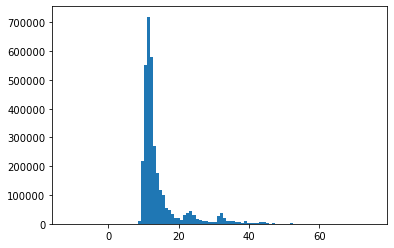

In [7]:
plt.hist(y_pred,bins=100);

What's the standard deviation of the predicted duration for this dataset?

In [8]:
y_pred.std()

6.247488852238703

Answer: __6.24__

# Q2. Preparing the output

First, let's create an artificial ride_id column:

In [9]:
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration,ride_id
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,...,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00,10.000000,2023/03_0
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,...,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25,31.083333,2023/03_1
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,...,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00,14.366667,2023/03_2
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,...,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00,11.466667,2023/03_3
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,...,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,3.033333,2023/03_4


In [19]:
df_result = df[['ride_id']].copy()
df_result['predicted_duration'] = y_pred
df_result.head()

,ride_id,predicted_duration
0,2023/03_0,16.245906
1,2023/03_1,26.134796
2,2023/03_2,11.884264
3,2023/03_3,11.997720
4,2023/03_4,10.234486


In [20]:
columns = ['ride_id', 'duration']
df_result.to_parquet(
    f'yellow_tripdata_{year:04d}-{month:02d}.parquet',
    engine='pyarrow',
    compression=None,
    index=False
)

In [22]:
!ls -lh | grep yellow

-rw-rw-rw- 1 codespace codespace 66M Jun 18 19:35 yellow_tripdata_2023-03.parquet


Answer: __66M__

# Q3. Creating the scoring script